### Arabidopsis ribosome profiling dataset (Wu et al. 2024; https://doi.org/10.1093/plcell/koad290)

#### Predict ORFs from transcriptome

In [1]:
from riboss.orfs import orf_finder
import pyranges as pr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

annotation = '../ref/tair10/Araport11_GTF_genes_transposons.current.bed'
tx = '../ref/tair10/Araport11_GTF_genes_transposons.current.pc.fa'
start_codon = ['ATG']
stop_codon = True

cds_range, df = orf_finder(annotation, tx, ncrna=False, outdir=None, start_codon=start_codon, stop_codon=stop_codon)

finding all ORFs       : 100%|████████████████████████████████| 48.3k/48.3k [00:40<00:00, 1.19kit/s]
converting coordinates : 100%|███████████████████████████████████| 876k/876k [00:04<00:00, 208kit/s]
converting coordinates : 100%|██████████████████████████████████| 886k/886k [00:26<00:00, 33.0kit/s]
INFO:root:found 280003 ORFs in 2 min 1 s
INFO:root:saved sequences as ../ref/tair10/Araport11_GTF_genes_transposons.current.transcripts.fa
INFO:root:saved sequences as ../ref/tair10/Araport11_GTF_genes_transposons.current.gp
INFO:root:saved sequences as ../ref/tair10/Araport11_GTF_genes_transposons.current.orf_finder.pkl.gz
INFO:root:saved CDS range as ../ref/tair10/Araport11_GTF_genes_transposons.current.cds_range.txt


In [2]:
df.value_counts('ORF_type')

ORF_type
dORF    160069
uORF     68042
mORF     48114
oORF      3778
Name: count, dtype: int64

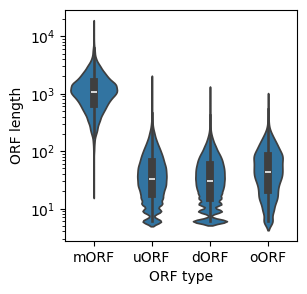

In [3]:
import os

fpath = '../results/wu_2024_datasets/orf_finder/' 
if not os.path.exists(fpath):
    os.makedirs(fpath)
    
plt.figure(figsize=(3,3))
sns.violinplot(data=df, x='ORF_type', y='ORF_length', log_scale=True)
plt.xlabel('ORF type')
plt.ylabel('ORF length')
plt.savefig(fpath + 'orf_finder.pdf', bbox_inches='tight')

#### Build a STAR index for the Arabidopsis transcriptome

In [1]:
import os
from riboss.wrapper import build_star_index

tx = '../ref/tair10/Araport11_GTF_genes_transposons.current.pc.fa'
index = os.path.split(tx)[0] + '/' + '.'.join(os.path.split(tx)[1].split(os.extsep)[:-1])

build_star_index(tx, index)

INFO:root:renamed ../ref/tair10/Araport11_GTF_genes_transposons.current.pc.fa as ../ref/tair10/Araport11_GTF_genes_transposons.current.pc.original.fasta
INFO:root:cleaned up fasta headers and saved as ../ref/tair10/Araport11_GTF_genes_transposons.current.pc.fa


	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode genomeGenerate --runThreadN 4 --genomeDir ../ref/tair10/Araport11_GTF_genes_transposons.current.pc --genomeFastaFiles ../ref/tair10/Araport11_GTF_genes_transposons.current.pc.fa --genomeSAindexNbases 7 --genomeChrBinNbits 11
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 05 13:14:05 ..... started STAR run
Feb 05 13:14:05 ... starting to generate Genome files
Feb 05 13:14:07 ... starting to sort Suffix Array. This may take a long time...
Feb 05 13:14:07 ... sorting Suffix Array chunks and saving them to disk...
Feb 05 13:14:36 ... loading chunks from disk, packing SA...
Feb 05 13:14:39 ... finished generating suffix array
Feb 05 13:14:39 ... generating Suffix Array index
Feb 05 13:14:39 ... completed Suffix Array index
Feb 05 13:14:39 ... writing Genome to disk ...
Feb 05 13:14:39 ... writing Suffix Array to disk ...


INFO:root:saved index to ../ref/tair10/Araport11_GTF_genes_transposons.current.pc


Feb 05 13:14:43 ... writing SAindex to disk
Feb 05 13:14:43 ..... finished successfully


#### Map ribosome footprints to transcriptome

In [1]:
import os
from glob import glob
import pandas as pd
from riboss.wrapper import align_short_reads


num_threads = 32
clip_3p_adapter_seq = 'AGATCGGAAGAGCACACGTCT'
sam_type = 'BAM Unsorted'
index = '../ref/tair10/Araport11_GTF_genes_transposons.current.pc'

fastqs = glob('../doc/wu_2024_datasets/*/*.fastq.gz')
fastqs = pd.DataFrame(fastqs)
fastqs['SRR'] = fastqs[0].str.split('/').str[-2]

rna = pd.merge(fastqs[fastqs[0].str.contains('_1.fastq.gz')], fastqs[fastqs[0].str.contains('_2.fastq.gz')], on='SRR')
rna['library'] = rna[['0_x','0_y']].values.tolist()
ribo = fastqs.drop_duplicates('SRR', keep=False)
ribo.columns = ['library','SRR']

In [2]:
for i in ribo['library'].tolist():
    prefix = os.path.split(i)[0] + '/' + '.'.join(os.path.split(i)[1].split(os.extsep)[:-2])
    align_short_reads(i, prefix, index, num_threads=num_threads, clip_3p_adapter_seq=clip_3p_adapter_seq, sam_type=sam_type)

	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/wu_2024_datasets/SRR15700011/SRR15700011.fastq.gz --outFileNamePrefix ../doc/wu_2024_datasets/SRR15700011/SRR15700011 --genomeDir ../ref/tair10/Araport11_GTF_genes_transposons.current.pc --runThreadN 32 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --clip3pAdapterSeq AGATCGGAAGAGCACACGTCT
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 05 16:02:23 ..... started STAR run
Feb 05 16:02:23 ..... loading genome
Feb 05 16:02:23 ..... started mapping


INFO:root:saved alignment to ../doc/wu_2024_datasets/SRR15700011/SRR15700011Aligned.out.bam


Feb 05 16:06:00 ..... finished mapping
Feb 05 16:06:00 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/wu_2024_datasets/SRR15700012/SRR15700012.fastq.gz --outFileNamePrefix ../doc/wu_2024_datasets/SRR15700012/SRR15700012 --genomeDir ../ref/tair10/Araport11_GTF_genes_transposons.current.pc --runThreadN 32 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --clip3pAdapterSeq AGATCGGAAGAGCACACGTCT
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 05 16:06:00 ..... started STAR run
Feb 05 16:06:00 ..... loading genome
Feb 05 16:06:00 ..... started mapping


INFO:root:saved alignment to ../doc/wu_2024_datasets/SRR15700012/SRR15700012Aligned.out.bam


Feb 05 16:09:50 ..... finished mapping
Feb 05 16:09:50 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/wu_2024_datasets/SRR15700010/SRR15700010.fastq.gz --outFileNamePrefix ../doc/wu_2024_datasets/SRR15700010/SRR15700010 --genomeDir ../ref/tair10/Araport11_GTF_genes_transposons.current.pc --runThreadN 32 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --clip3pAdapterSeq AGATCGGAAGAGCACACGTCT
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 05 16:09:52 ..... started STAR run
Feb 05 16:09:52 ..... loading genome
Feb 05 16:09:52 ..... started mapping


INFO:root:saved alignment to ../doc/wu_2024_datasets/SRR15700010/SRR15700010Aligned.out.bam


Feb 05 16:13:47 ..... finished mapping
Feb 05 16:13:47 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/wu_2024_datasets/SRR15700013/SRR15700013.fastq.gz --outFileNamePrefix ../doc/wu_2024_datasets/SRR15700013/SRR15700013 --genomeDir ../ref/tair10/Araport11_GTF_genes_transposons.current.pc --runThreadN 32 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --clip3pAdapterSeq AGATCGGAAGAGCACACGTCT
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 05 16:13:49 ..... started STAR run
Feb 05 16:13:49 ..... loading genome
Feb 05 16:13:49 ..... started mapping


INFO:root:saved alignment to ../doc/wu_2024_datasets/SRR15700013/SRR15700013Aligned.out.bam


Feb 05 16:17:37 ..... finished mapping
Feb 05 16:17:37 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/wu_2024_datasets/SRR15700008/SRR15700008.fastq.gz --outFileNamePrefix ../doc/wu_2024_datasets/SRR15700008/SRR15700008 --genomeDir ../ref/tair10/Araport11_GTF_genes_transposons.current.pc --runThreadN 32 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --clip3pAdapterSeq AGATCGGAAGAGCACACGTCT
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 05 16:17:37 ..... started STAR run
Feb 05 16:17:37 ..... loading genome
Feb 05 16:17:37 ..... started mapping


INFO:root:saved alignment to ../doc/wu_2024_datasets/SRR15700008/SRR15700008Aligned.out.bam


Feb 05 16:21:00 ..... finished mapping
Feb 05 16:21:00 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/wu_2024_datasets/SRR15700009/SRR15700009.fastq.gz --outFileNamePrefix ../doc/wu_2024_datasets/SRR15700009/SRR15700009 --genomeDir ../ref/tair10/Araport11_GTF_genes_transposons.current.pc --runThreadN 32 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --clip3pAdapterSeq AGATCGGAAGAGCACACGTCT
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 05 16:21:01 ..... started STAR run
Feb 05 16:21:01 ..... loading genome
Feb 05 16:21:01 ..... started mapping


INFO:root:saved alignment to ../doc/wu_2024_datasets/SRR15700009/SRR15700009Aligned.out.bam


Feb 05 16:24:32 ..... finished mapping
Feb 05 16:24:32 ..... finished successfully


In [2]:
for lib in rna['library'].tolist():
    i = lib[0]
    prefix = os.path.split(i)[0] + '/' + '.'.join(os.path.split(i)[1].split(os.extsep)[:-2])
    prefix = prefix.replace('_1','')
    align_short_reads(lib, prefix, index, num_threads=num_threads, clip_3p_adapter_seq=clip_3p_adapter_seq, sam_type=sam_type)

	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/wu_2024_datasets/SRR15700002/SRR15700002_1.fastq.gz ../doc/wu_2024_datasets/SRR15700002/SRR15700002_2.fastq.gz --outFileNamePrefix ../doc/wu_2024_datasets/SRR15700002/SRR15700002 --genomeDir ../ref/tair10/Araport11_GTF_genes_transposons.current.pc --runThreadN 32 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --clip3pAdapterSeq AGATCGGAAGAGCACACGTCT AGATCGGAAGAGCACACGTCT --clip3pAdapterMMp 0.1 0.1
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 06 10:56:49 ..... started STAR run
Feb 06 10:56:49 ..... loading genome
Feb 06 10:56:49 ..... started mapping


INFO:root:saved alignment to ../doc/wu_2024_datasets/SRR15700002/SRR15700002Aligned.out.bam


Feb 06 10:58:19 ..... finished mapping
Feb 06 10:58:19 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/wu_2024_datasets/SRR15700005/SRR15700005_1.fastq.gz ../doc/wu_2024_datasets/SRR15700005/SRR15700005_2.fastq.gz --outFileNamePrefix ../doc/wu_2024_datasets/SRR15700005/SRR15700005 --genomeDir ../ref/tair10/Araport11_GTF_genes_transposons.current.pc --runThreadN 32 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --clip3pAdapterSeq AGATCGGAAGAGCACACGTCT AGATCGGAAGAGCACACGTCT --clip3pAdapterMMp 0.1 0.1
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 06 10:58:20 ..... started STAR run
Feb 06 10:58:20 ..... loading genome
Feb 06 10:58:20 ..... started mapping
Feb 06 11:00:22 ..... finished mapping
Feb

INFO:root:saved alignment to ../doc/wu_2024_datasets/SRR15700005/SRR15700005Aligned.out.bam


	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/wu_2024_datasets/SRR15700003/SRR15700003_1.fastq.gz ../doc/wu_2024_datasets/SRR15700003/SRR15700003_2.fastq.gz --outFileNamePrefix ../doc/wu_2024_datasets/SRR15700003/SRR15700003 --genomeDir ../ref/tair10/Araport11_GTF_genes_transposons.current.pc --runThreadN 32 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --clip3pAdapterSeq AGATCGGAAGAGCACACGTCT AGATCGGAAGAGCACACGTCT --clip3pAdapterMMp 0.1 0.1
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 06 11:00:22 ..... started STAR run
Feb 06 11:00:22 ..... loading genome
Feb 06 11:00:22 ..... started mapping


INFO:root:saved alignment to ../doc/wu_2024_datasets/SRR15700003/SRR15700003Aligned.out.bam


Feb 06 11:02:20 ..... finished mapping
Feb 06 11:02:20 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/wu_2024_datasets/SRR15700004/SRR15700004_1.fastq.gz ../doc/wu_2024_datasets/SRR15700004/SRR15700004_2.fastq.gz --outFileNamePrefix ../doc/wu_2024_datasets/SRR15700004/SRR15700004 --genomeDir ../ref/tair10/Araport11_GTF_genes_transposons.current.pc --runThreadN 32 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --clip3pAdapterSeq AGATCGGAAGAGCACACGTCT AGATCGGAAGAGCACACGTCT --clip3pAdapterMMp 0.1 0.1
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 06 11:02:20 ..... started STAR run
Feb 06 11:02:20 ..... loading genome
Feb 06 11:02:20 ..... started mapping


INFO:root:saved alignment to ../doc/wu_2024_datasets/SRR15700004/SRR15700004Aligned.out.bam


Feb 06 11:04:12 ..... finished mapping
Feb 06 11:04:12 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/wu_2024_datasets/SRR15700007/SRR15700007_1.fastq.gz ../doc/wu_2024_datasets/SRR15700007/SRR15700007_2.fastq.gz --outFileNamePrefix ../doc/wu_2024_datasets/SRR15700007/SRR15700007 --genomeDir ../ref/tair10/Araport11_GTF_genes_transposons.current.pc --runThreadN 32 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --clip3pAdapterSeq AGATCGGAAGAGCACACGTCT AGATCGGAAGAGCACACGTCT --clip3pAdapterMMp 0.1 0.1
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 06 11:04:13 ..... started STAR run
Feb 06 11:04:13 ..... loading genome
Feb 06 11:04:13 ..... started mapping


INFO:root:saved alignment to ../doc/wu_2024_datasets/SRR15700007/SRR15700007Aligned.out.bam


Feb 06 11:06:20 ..... finished mapping
Feb 06 11:06:20 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/wu_2024_datasets/SRR15700006/SRR15700006_1.fastq.gz ../doc/wu_2024_datasets/SRR15700006/SRR15700006_2.fastq.gz --outFileNamePrefix ../doc/wu_2024_datasets/SRR15700006/SRR15700006 --genomeDir ../ref/tair10/Araport11_GTF_genes_transposons.current.pc --runThreadN 32 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --clip3pAdapterSeq AGATCGGAAGAGCACACGTCT AGATCGGAAGAGCACACGTCT --clip3pAdapterMMp 0.1 0.1
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 06 11:06:21 ..... started STAR run
Feb 06 11:06:21 ..... loading genome
Feb 06 11:06:21 ..... started mapping
Feb 06 11:08:23 ..... finished mapping
Feb

INFO:root:saved alignment to ../doc/wu_2024_datasets/SRR15700006/SRR15700006Aligned.out.bam


#### Analyse ribosome footprints

In [1]:
import numpy as np
import pandas as pd
import logging
import os
from glob import glob
from riboss.footprints import analyse_footprints


fastqs = glob('../doc/wu_2024_datasets/*/*.fastq.gz')
fastqs = pd.DataFrame(fastqs)
fastqs['SRR'] = fastqs[0].str.split('/').str[-2]

rna = fastqs[fastqs[0].str.contains('_1.fastq.gz')].copy()
rna['BAM'] = rna[0].str.replace('_1.fastq.gz','Aligned.out.bam')
ribo = fastqs.drop_duplicates('SRR', keep=False).copy()
ribo['BAM'] = ribo[0].str.replace('.fastq.gz','Aligned.out.bam')

downsampling BAM       : 93174147it [01:39, 935388.47it/s] 
comparing periodicity  : 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 23.72it/s]
INFO:root:saved selected footprint sizes with an offset as ../results/wu_2024_datasets/analyse_footprints/SRR15700011Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as ../results/wu_2024_datasets/analyse_footprints/SRR15700011Aligned.out.frames.pdf
INFO:root:saved metagene plots as ../results/wu_2024_datasets/analyse_footprints/SRR15700011Aligned.out.start_codon.pdf and ../results/wu_2024_datasets/analyse_footprints/SRR15700011Aligned.out.stop_codon.pdf
downsampling BAM       : 94394402it [01:39, 945491.77it/s] 
comparing periodicity  : 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 24.11it/s]
INFO:root:saved selected footprint sizes with an offset as ../results/wu_2024_datasets/analyse_footprints/SRR15700012Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as ../res

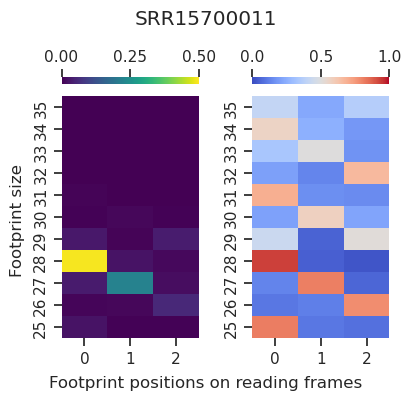

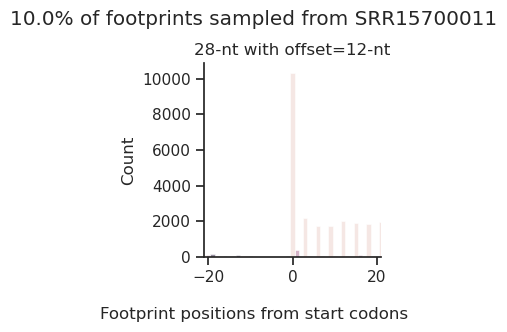

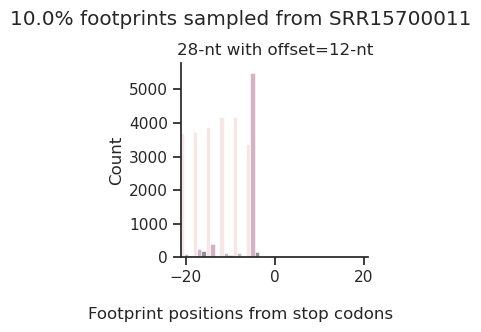

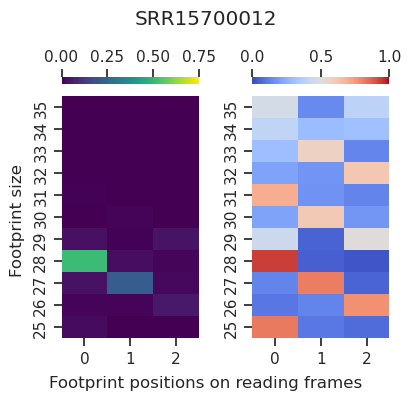

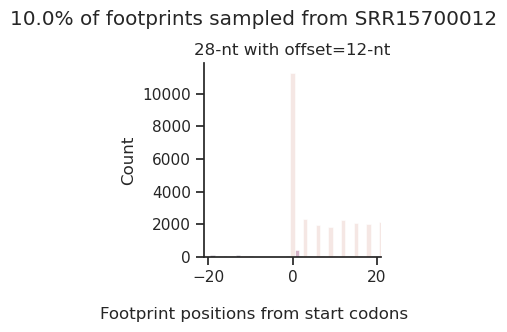

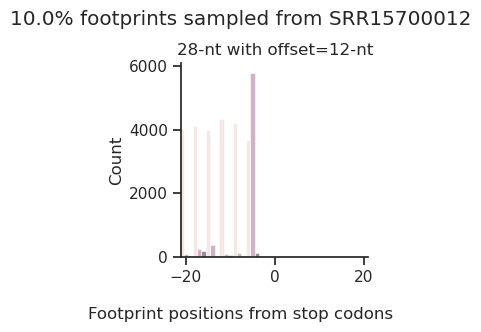

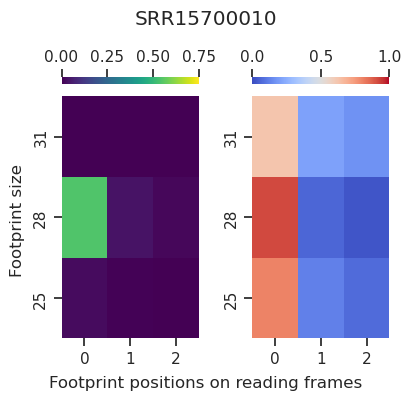

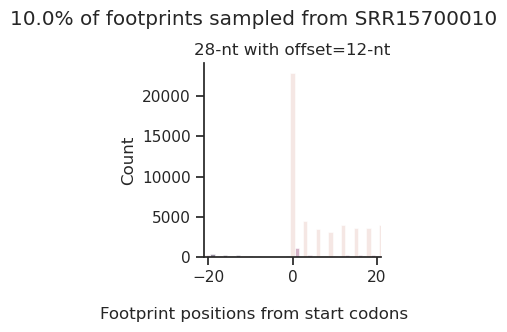

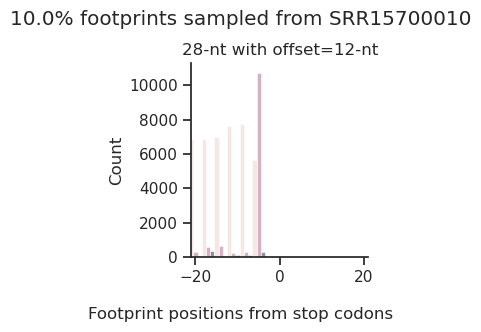

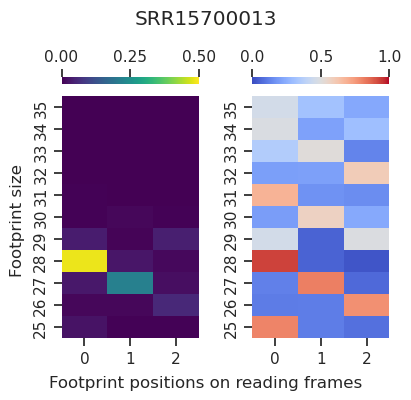

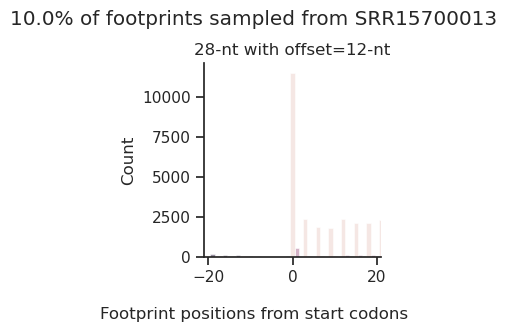

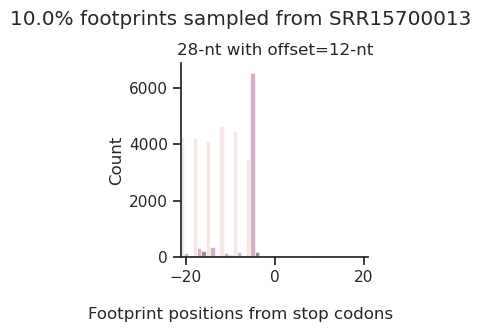

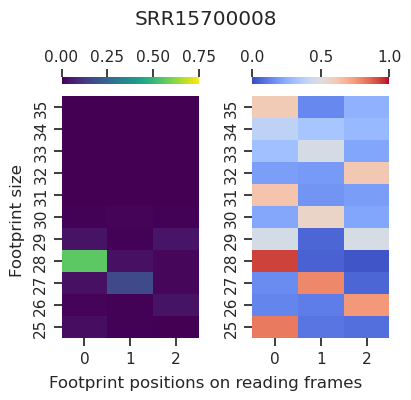

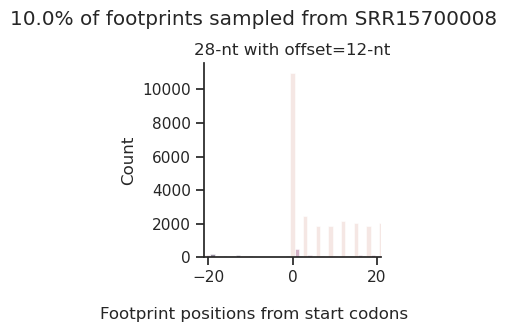

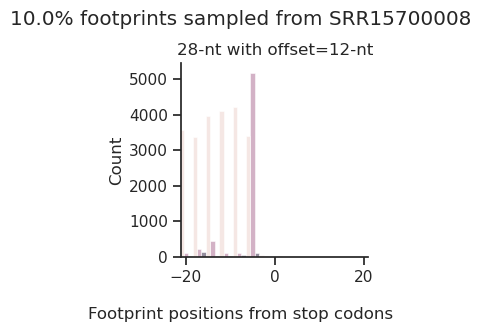

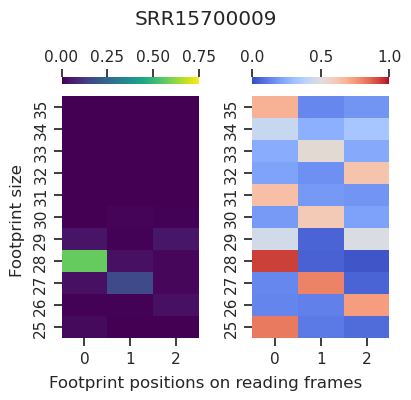

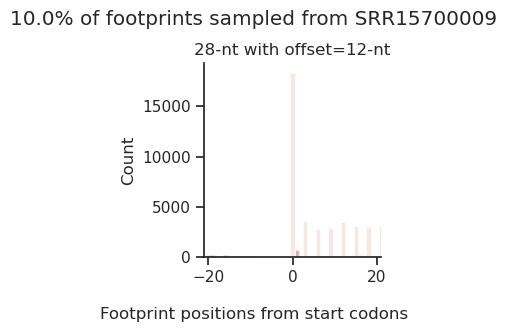

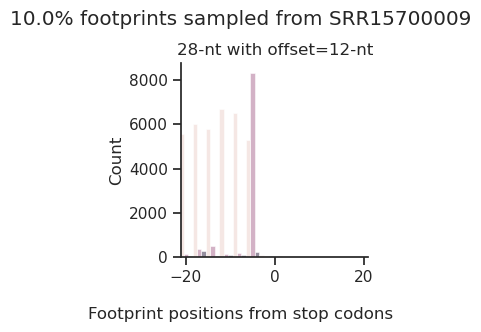

In [2]:
offset_method = '5p'
adj = 12
downsampling = 0.1
outdir = '../results/wu_2024_datasets/analyse_footprints'
cds_range = '../ref/tair10/Araport11_GTF_genes_transposons.current.cds_range.txt'


for i in ribo['BAM'].tolist():
    _ = analyse_footprints(offset_method, adj, i, downsampling, cds_range, 'best', outdir)

downsampling BAM       : 31272326it [00:46, 670018.10it/s]
comparing periodicity  : 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 23.66it/s]
INFO:root:saved selected footprint sizes with an offset as ../results/wu_2024_datasets/analyse_footprints/SRR15700002Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as ../results/wu_2024_datasets/analyse_footprints/SRR15700002Aligned.out.frames.pdf
INFO:root:saved metagene plots as ../results/wu_2024_datasets/analyse_footprints/SRR15700002Aligned.out.start_codon.pdf and ../results/wu_2024_datasets/analyse_footprints/SRR15700002Aligned.out.stop_codon.pdf
downsampling BAM       : 45546828it [01:05, 694041.56it/s]
comparing periodicity  : 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 23.20it/s]
INFO:root:saved selected footprint sizes with an offset as ../results/wu_2024_datasets/analyse_footprints/SRR15700005Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as ../resul

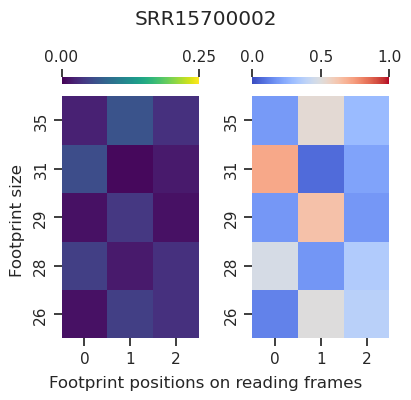

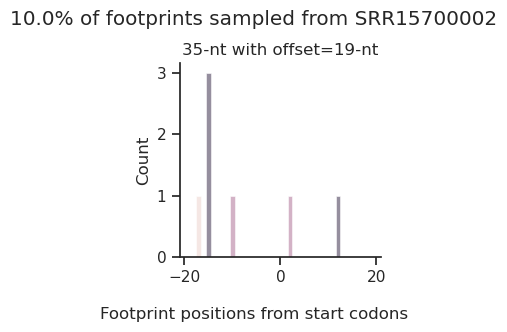

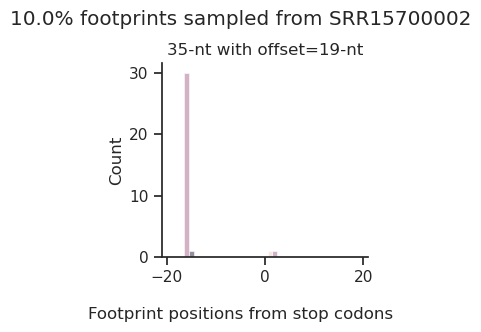

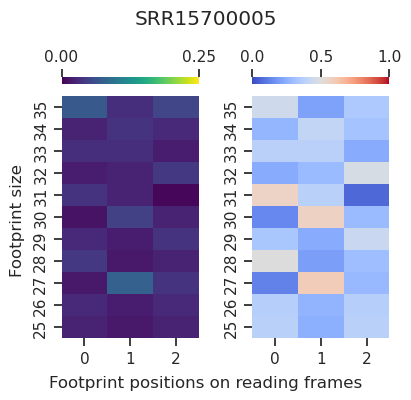

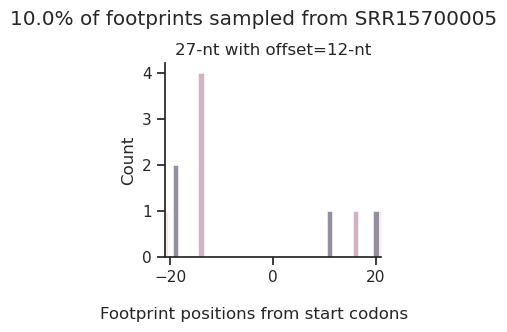

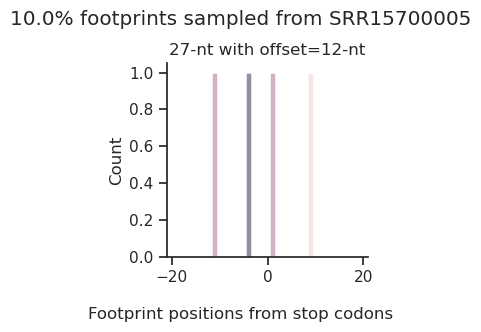

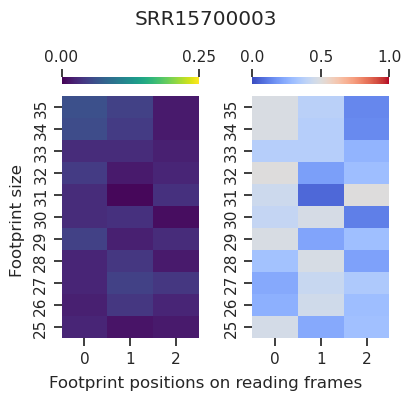

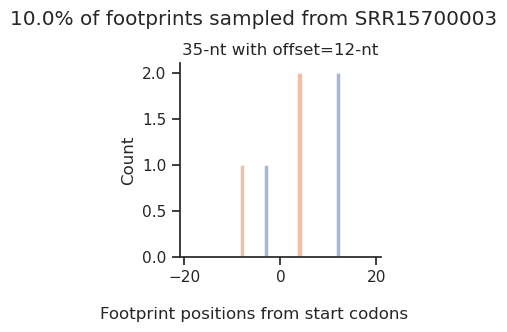

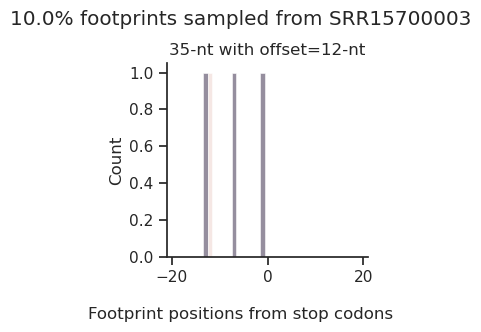

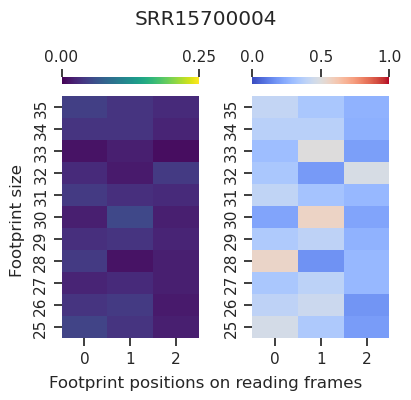

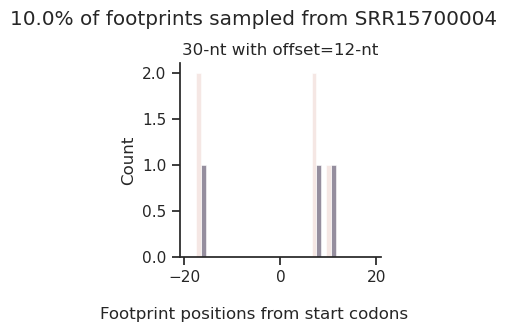

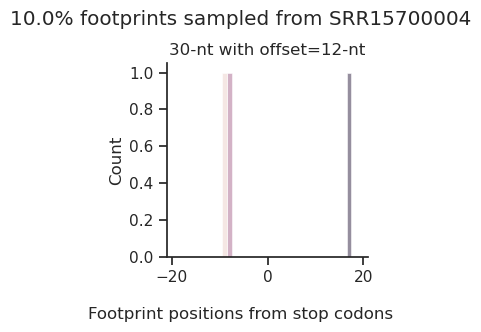

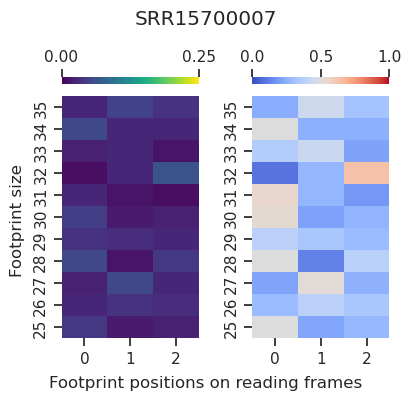

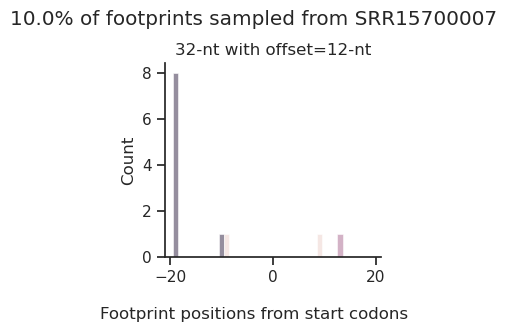

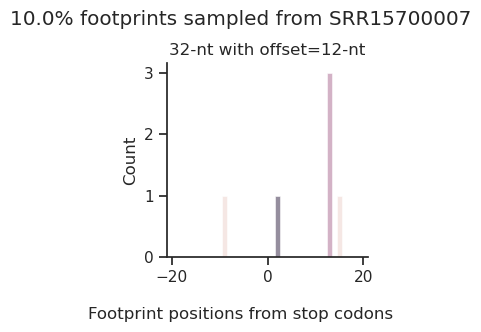

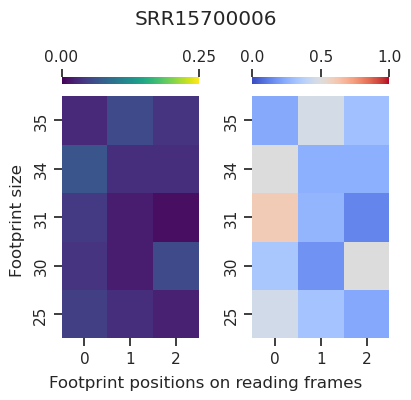

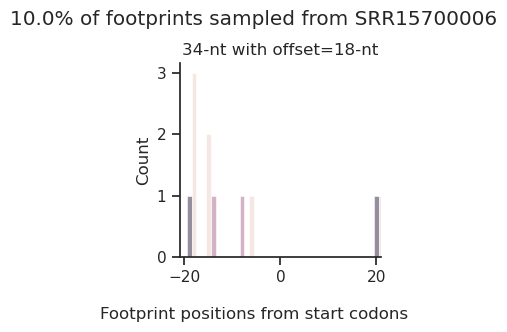

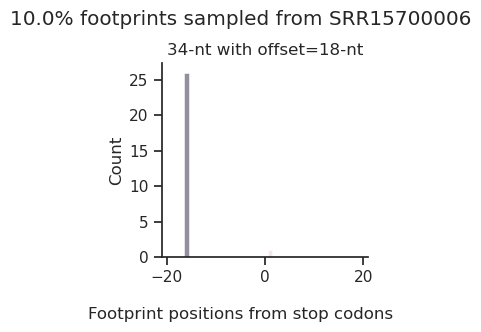

In [3]:
offset_method = '5p'
adj = 12
downsampling = 0.1
outdir = '../results/wu_2024_datasets/analyse_footprints'
cds_range = '../ref/tair10/Araport11_GTF_genes_transposons.current.cds_range.txt'

for i in rna['BAM'].tolist():
    try:
        _ = analyse_footprints(offset_method, adj, i, downsampling, cds_range, 'best', outdir)
    except Exception as e:
        logging.exception('Expected errors for RNA-seq library.')
        pass

#### Merge ribosome profiling and matched RNA-seq data

In [1]:
! samtools merge \
../doc/wu_2024_datasets/SRR15700002/SRR15700002Aligned.out.bam \
../doc/wu_2024_datasets/SRR15700003/SRR15700003Aligned.out.bam \
../doc/wu_2024_datasets/SRR15700004/SRR15700004Aligned.out.bam \
../doc/wu_2024_datasets/SRR15700005/SRR15700005Aligned.out.bam \
../doc/wu_2024_datasets/SRR15700006/SRR15700006Aligned.out.bam \
../doc/wu_2024_datasets/SRR15700007/SRR15700007Aligned.out.bam \
-f -o ../doc/wu_2024_datasets/SRR15700002_7.bam
! samtools merge \
../doc/wu_2024_datasets/SRR15700008/SRR15700008Aligned.out.bam \
../doc/wu_2024_datasets/SRR15700009/SRR15700009Aligned.out.bam \
../doc/wu_2024_datasets/SRR15700010/SRR15700010Aligned.out.bam \
../doc/wu_2024_datasets/SRR15700011/SRR15700011Aligned.out.bam \
../doc/wu_2024_datasets/SRR15700012/SRR15700012Aligned.out.bam \
../doc/wu_2024_datasets/SRR15700013/SRR15700013Aligned.out.bam \
-f -o ../doc/wu_2024_datasets/SRR15700008_13.bam

! samtools sort ../doc/wu_2024_datasets/SRR15700002_7.bam -o ../doc/wu_2024_datasets/SRR15700002_7.sorted.bam
! samtools sort ../doc/wu_2024_datasets/SRR15700008_13.bam -o ../doc/wu_2024_datasets/SRR15700008_13.sorted.bam

! mv ../doc/wu_2024_datasets/SRR15700002_7.sorted.bam ../doc/wu_2024_datasets/SRR15700002_7.bam
! mv ../doc/wu_2024_datasets/SRR15700008_13.sorted.bam ../doc/wu_2024_datasets/SRR15700008_13.bam

! samtools collate -u -O ../doc/wu_2024_datasets/SRR15700002_7.bam \
| samtools fastq \
-1 ../doc/wu_2024_datasets/SRR15700002_7.1.fastq.gz \
-2 ../doc/wu_2024_datasets/SRR15700002_7.2.fastq.gz \
-0 /dev/null -s /dev/null -n

#### Merge footprint offset files

In [4]:
! ls ../results/wu_2024_datasets/analyse_footprints/*.txt | tail -n6 \
| sed '1i cat' | sed 's/$/ \\/' \
| sed -e $'$a\\> ../results/wu_2024_datasets/analyse_footprints/offset.txt' | sh

! cat ../results/wu_2024_datasets/analyse_footprints/offset.txt

28	12
28	12
28	12
28	12
28	12
28	12


In [5]:
! awk '!seen[$1]++' ../results/wu_2024_datasets/analyse_footprints/offset.txt \
> ../results/wu_2024_datasets/analyse_footprints/SRR15700008_13Aligned.out.offset.txt

#### Build salmon index using transcriptome assembly and run salmon quant

In [1]:
from riboss.wrapper import quantify_transcripts

index = '../ref/tair10/Araport11_GTF_genes_transposons.current.pc_puff'
tx = '../ref/tair10/Araport11_GTF_genes_transposons.current.pc.fa'
reads = ['../doc/wu_2024_datasets/SRR15700002_7.1.fastq.gz','../doc/wu_2024_datasets/SRR15700002_7.2.fastq.gz']
outdir = '../doc/wu_2024_datasets/'
clip_3p_adapter_seq = 'AGATCGGAAGAGCACACGTCT'

quantify_transcripts(reads, tx, adapter=clip_3p_adapter_seq, index=index, outdir=outdir)

Version Info: This is the most recent version of salmon.
[2025-02-06 12:58:00.871] [jLog] [warning] The salmon index is being built without any decoy sequences.  It is recommended that decoy sequence (either computed auxiliary decoy sequence or the genome of the organism) be provided during indexing. Further details can be found at https://salmon.readthedocs.io/en/latest/salmon.html#preparing-transcriptome-indices-mapping-based-mode.
[2025-02-06 12:58:00.871] [jLog] [info] building index
out : ../ref/tair10/Araport11_GTF_genes_transposons.current.pc_puff
[2025-02-06 12:58:00.872] [puff::index::jointLog] [info] Running fixFasta

[Step 1 of 4] : counting k-mers
[2025-02-06 12:58:01.153] [puff::index::jointLog] [warning] Entry with header [AT1G33355.1], had length less than equal to the k-mer length of 31 (perhaps after poly-A clipping)
[2025-02-06 12:58:01.317] [puff::index::jointLog] [warning] Entry with header [AT1G64633.1], had length less than equal to the k-mer length of 31 (perhaps

Threads = 2
Vertex length = 31
Hash functions = 5
Filter size = 1073741824
Capacity = 2
Files: 
../ref/tair10/Araport11_GTF_genes_transposons.current.pc_puff/ref_k31_fixed.fa
--------------------------------------------------------------------------------
Round 0, 0:1073741824
Pass	Filling	Filtering
1	7	23	
2	1	0
True junctions count = 109885
False junctions count = 231817
Hash table size = 341702
Candidate marks count = 790873
--------------------------------------------------------------------------------
Reallocating bifurcations time: 0
True marks count: 441030
Edges construction time: 2
--------------------------------------------------------------------------------
Distinct junctions = 109885



TwoPaCo::buildGraphMain:: allocated with scalable_malloc; freeing.
TwoPaCo::buildGraphMain:: Calling scalable_allocation_command(TBBMALLOC_CLEAN_ALL_BUFFERS, 0);
allowedIn: 12
Max Junction ID: 155875
seen.size():1247009 kmerInfo.size():155876
approximateContigTotalLength: 37788998
counters for complex kmers:
(prec>1 & succ>1)=1733 | (succ>1 & isStart)=20 | (prec>1 & isEnd)=29 | (isStart & isEnd)=30
contig count: 169954 element count: 50623090 complex nodes: 1812
# of ones in rank vector: 169953
[2025-02-06 12:58:42.147] [puff::index::jointLog] [info] Starting the Pufferfish indexing by reading the GFA binary file.
[2025-02-06 12:58:42.147] [puff::index::jointLog] [info] Setting the index/BinaryGfa directory ../ref/tair10/Araport11_GTF_genes_transposons.current.pc_puff
size = 50623090
-----------------------------------------
| Loading contigs | Time = 25.473 ms
-----------------------------------------
size = 50623090
-----------------------------------------
| Loading contig boundarie

for info, total work write each  : 2.331    total work inram from level 3 : 4.322  total work raw : 25.000 
Bitarray       238539584  bits (100.00 %)   (array + ranks )
final hash             0  bits (0.00 %) (nb in final hash 0)


Read1 before filtering:
total reads: 78512786
total bases: 7851278600
Q20 bases: 7806904541(99.4348%)
Q30 bases: 7703607219(98.1191%)

Read2 before filtering:
total reads: 78512786
total bases: 7851278600
Q20 bases: 7739257877(98.5732%)
Q30 bases: 7558027618(96.2649%)

Read1 after filtering:
total reads: 78476368
total bases: 7812342456
Q20 bases: 7768456897(99.4383%)
Q30 bases: 7666039884(98.1273%)

Read2 after filtering:
total reads: 78476368
total bases: 7812024864
Q20 bases: 7701226174(98.5817%)
Q30 bases: 7521198934(96.2772%)

Filtering result:
reads passed filter: 156952736
reads failed due to low quality: 0
reads failed due to too many N: 72802
reads failed due to too short: 34
reads with adapter trimmed: 6494094
bases trimmed due to adapters: 70931457

Duplication rate: 43.3553%

Insert size peak (evaluated by paired-end reads): 142

JSON report: fastp.json
HTML report: fastp.html

fastp -i ../doc/wu_2024_datasets/SRR15700002_7.1.fastq.gz -I ../doc/wu_2024_datasets/SRR15700002_

#### Assign footprints to transcripts using riboprof (ribomap)

In [1]:
from riboss.wrapper import riboprofiler

offset = '../results/wu_2024_datasets/analyse_footprints/SRR15700008_13Aligned.out.offset.txt'
mrnabam = '../doc/wu_2024_datasets/SRR15700002_7.bam'
ribobam = '../doc/wu_2024_datasets/SRR15700008_13.bam'
tx = '../ref/tair10/Araport11_GTF_genes_transposons.current.pc.fa'
sf = '../doc/wu_2024_datasets/SRR15700002_7_salmon_quant/quant.sf'
out = '../results/wu_2024_datasets/riboprofiler/SRR15700008_13'
cds_range_file = '../ref/tair10/Araport11_GTF_genes_transposons.current.pc.cds_range.txt'

riboprof_base = riboprofiler(offset, ribobam, mrnabam, 
                             tx, cds_range_file, 
                             sf, out)

getting transcript info...
total number of transcripts in transcriptome: 48270
assigning ribo-seq reads...
constructing profile class...
number of transcripts in profile class: 38250
loading reads from bam...
getting readlen mapping to P site offset...
getting alignment records...
total number of reads: 302788396
getting read type and p-sites...
total output footprint: 302788396
total: 302788396        multi_mapped: 73993039 (24.44 %)
assigning reads to frame 0 loci...
reads used: 158631217 reads assigned: 158631217
assigning reads to frame 1 and 2 loci...
reads used: 168448099 reads assigned: 168448099
assigning reads to UTR loci...
reads used: 169684906 reads assigned: 169684906
assigning RNA-seq reads...
number of transcripts in profile class: 38250
loading reads from bam...
getting alignment records...
total number of reads: 78482163
getting read type and p-sites...
total output footprint: 78482163
total: 78482163 multi_mapped: 22796058 (29.05 %)
assigning reads...
reads used: 7848

INFO:root:saved main output as ../results/wu_2024_datasets/riboprofiler/SRR15700008_13.base


#### Find new ORFs using the main RIBOSS function

##### Use RNA-seq as negatives

In [1]:
import pandas as pd
from riboss.riboss import riboss

superkingdom = 'Eukaryota'
tx = '../ref/tair10/Araport11_GTF_genes_transposons.current.pc.fa'
fasta = '../ref/tair10/TAIR10_chr_all.fas'
riboprof_base = '../results/wu_2024_datasets/riboprofiler/SRR15700008_13.base'
profile='rna'
bed = '../ref/tair10/Araport11_GTF_genes_transposons.current.bed'
outdir = '../results/wu_2024_datasets/riboss_rnaseq'
padj_method = 'fdr_bh'
tie = True
num_simulations = 1000
email='chunshen.lim@otago.ac.nz'
api_key='55890b8dfafe4d49e57c5f1d031aec4c2509'
df = pd.read_pickle('../ref/tair10/Araport11_GTF_genes_transposons.current.orf_finder.pkl.gz')


boss_df, sig, blast, tophits, ipg = riboss(superkingdom, df, riboprof_base, profile, fasta, tx, bed=bed,
                                           padj_method=padj_method, tie=tie, num_simulations=num_simulations, 
                                           run_blastp=True, run_efetch=True, verbose=True,
                                           email=email, api_key=api_key, outdir=outdir)

parsing ribomap output : 100%|████████████████████████████████| 36.6k/36.6k [00:15<00:00, 2.42kit/s]
parsing ribomap output : 100%|████████████████████████████████| 36.6k/36.6k [00:15<00:00, 2.37kit/s]
INFO:root:saved rprofile as ../results/wu_2024_datasets/riboss_rnaseq/SRR15700008_13.riboprof.rprofile.plus.bg and ../results/wu_2024_datasets/riboss_rnaseq/SRR15700008_13.riboprof.rprofile.minus.bg
counting footprints    : 100%|██████████████████████████████████| 229k/229k [00:04<00:00, 46.2kit/s]
ERROR:root:boss error: cannot unpack non-iterable NoneType object


SystemExit: 1

/home/limch05p/miniforge3/envs/riboss/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


##### Use ribosome-profiling as positives

parsing ribomap output : 100%|████████████████████████████████| 36.6k/36.6k [00:14<00:00, 2.45kit/s]
parsing ribomap output : 100%|████████████████████████████████| 36.6k/36.6k [00:15<00:00, 2.36kit/s]
INFO:root:saved rprofile as ../results/wu_2024_datasets/riboss/SRR15700008_13.riboprof.rprofile.plus.bg and ../results/wu_2024_datasets/riboss/SRR15700008_13.riboprof.rprofile.minus.bg
counting footprints    : 100%|██████████████████████████████████| 229k/229k [00:05<00:00, 45.6kit/s]
comparing periodicity  : 100%|██████████████████████████████████| 5359/5359 [03:41<00:00, 24.21it/s]
INFO:root:saved RIBOSS stats as ../results/wu_2024_datasets/riboss/SRR15700008_13.riboss.boss.pkl and ../results/wu_2024_datasets/riboss/SRR15700008_13.riboss.boss.csv
INFO:root:saved significant RIBOSS results (n=38) as ../results/wu_2024_datasets/riboss/SRR15700008_13.riboss.sig.pkl
--2025-02-20 11:42:56--  https://genome.ucsc.edu/goldenpath/help/examples/bigGenePred.as
Resolving genome.ucsc.edu (genome.uc

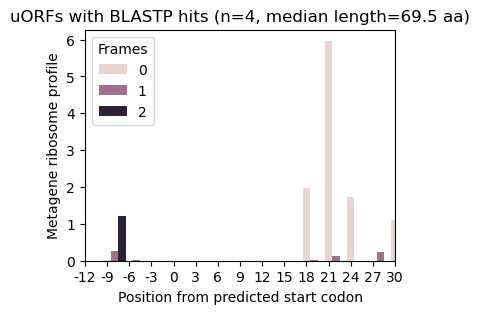

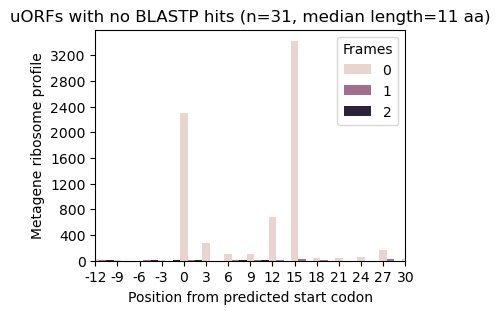

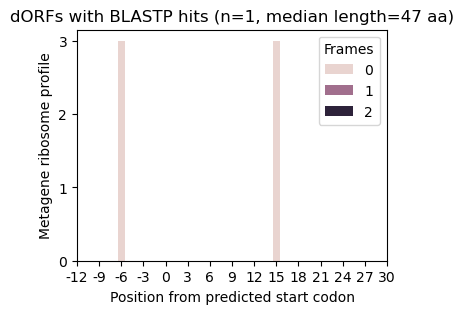

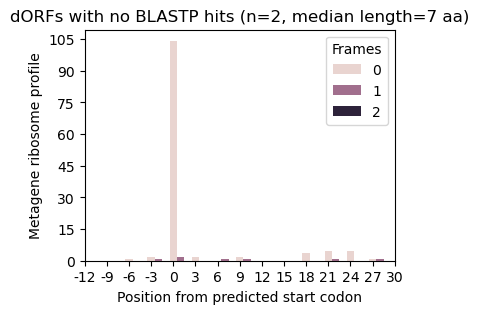

In [1]:
import pandas as pd
from riboss.riboss import riboss

superkingdom = 'Eukaryota'
tx = '../ref/tair10/Araport11_GTF_genes_transposons.current.pc.fa'
fasta = '../ref/tair10/TAIR10_chr_all.fas'
riboprof_base = '../results/wu_2024_datasets/riboprofiler/SRR15700008_13.base'
profile='ribo'
bed = '../ref/tair10/Araport11_GTF_genes_transposons.current.bed'
outdir = '../results/wu_2024_datasets/riboss'
padj_method = 'fdr_bh'
tie = True #False
num_simulations = 1000
email='chunshen.lim@otago.ac.nz'
api_key='55890b8dfafe4d49e57c5f1d031aec4c2509'
df = pd.read_pickle('../ref/tair10/Araport11_GTF_genes_transposons.current.orf_finder.pkl.gz')


boss_df, sig, blast, tophits, ipg = riboss(superkingdom, df, riboprof_base, profile, fasta, tx, bed=bed,
                                           padj_method='fdr_bh', tie=tie, num_simulations=num_simulations, 
                                           run_blastp=True, run_efetch=True, verbose=True,
                                           email=email, api_key=api_key, outdir=outdir)

In [2]:
boss_df.shape, sig.shape, blast.shape, tophits.shape

((34668, 14), (38, 20), (139, 15), (38, 26))

In [3]:
boss_df.value_counts('boss')

boss
default    29309
tie         2842
mORF        2459
uORF          55
dORF           3
Name: count, dtype: int64

In [4]:
boss_df.value_counts(['boss','ORF_type_x'])

boss     ORF_type_x
tie      uORF          2711
mORF     uORF          2306
         dORF           153
tie      dORF           129
default  uORF            89
uORF     uORF            55
default  dORF            14
dORF     dORF             3
tie      oORF             2
Name: count, dtype: int64

#### Validate the genePred file for uORFs

In [2]:
! bedtools getfasta -bed ../results/wu_2024_datasets/riboss/SRR15700008_13.riboss.boss_tie.uORF.bed -fi ../ref/tair10/TAIR10_chr_all.fas -split -name -s -tab \
| cut -f2 | cut -c-3 | sort | uniq -c

   2855 ATG


In [3]:
! bedtools getfasta -bed ../results/wu_2024_datasets/riboss/SRR15700008_13.riboss.boss_tie.uORF.bed -fi ../ref/tair10/TAIR10_chr_all.fas -split -name -s -tab \
| cut -f2 | rev | cut -c-3 | sort | uniq -c

   1046 AAT
   1184 AGT
    625 GAT


#### Araport uORFs found using RIBOSS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##### Ribo-Seq ORFs that have over 10 mapped footprints

In [2]:
! cat \
<(awk 'BEGIN{OFS="\t"} {print $1,$2,$3,"riboprof",$4,"+"}' ../results/wu_2024_datasets/riboss/SRR15700008_13.riboprof.rprofile.plus.bg) \
<(awk 'BEGIN{OFS="\t"} {print $1,$2,$3,"riboprof",$4,"-"}' ../results/wu_2024_datasets/riboss/SRR15700008_13.riboprof.rprofile.minus.bg) \
| bedtools intersect -a ../ref/tair10/Araport11_GTF_genes_transposons.current.uorfs.uniq.bed -b - \
-s -split -wo | datamash -s -g1,2,3,4,5,6,7,8,9,10,11,12 sum 19 \
| cut -f4,13 > ../results/wu_2024_datasets/riboss/SRR15700008_13.riboprof.araport.txt

! wc -l ../results/wu_2024_datasets/riboss/SRR15700008_13.riboprof.araport.txt

96 ../results/wu_2024_datasets/riboss/SRR15700008_13.riboprof.araport.txt


In [3]:
of_rs_counts = pd.read_csv('../results/wu_2024_datasets/riboss/SRR15700008_13.riboprof.araport.txt', sep='\t', header=None)
of_rs_counts.columns = ['Araport_uORF','counts']
of_rs_counts.shape, of_rs_counts[of_rs_counts['counts']>10].shape

((96, 2), (92, 2))

##### Get Araport uORFs that overlap the non-canonical ORFs in the boss results

In [4]:
! cat \
../results/wu_2024_datasets/riboss/SRR15700008_13.riboss.boss_tie.uORF.bed \
../results/wu_2024_datasets/riboss/SRR15700008_13.riboss.boss_tie.oORF.bed \
../results/wu_2024_datasets/riboss/SRR15700008_13.riboss.boss_tie.dORF.bed \
| bedtools intersect -a - -b ../ref/tair10/Araport11_GTF_genes_transposons.current.uorfs.uniq.bed \
-s -split -wo | awk '($2==$14) && ($3==$15)' \
> ../results/wu_2024_datasets/riboss/SRR15700008_13.boss.araport.txt

! wc -l ../results/wu_2024_datasets/riboss/SRR15700008_13.boss.araport.txt

52 ../results/wu_2024_datasets/riboss/SRR15700008_13.boss.araport.txt


##### Get all Araport uORFs detected by RIBOSS orf_finder

In [5]:
! awk 'BEGIN{OFS="\t"} NR>1 {print $1,$8,$9,$2 "__" $5 "-" $6 "|" $NF,$7,$3}' ../results/wu_2024_datasets/orf_finder/Araport11_GTF_genes_transposons.current.orf_finder.txt \
| bedtools intersect -a - -b ../ref/tair10/Araport11_GTF_genes_transposons.current.uorfs.uniq.bed -s -split -wo \
| awk '(($2==$8) || ($3==$9))' \
> ../ref/tair10/Araport11_GTF_genes_transposons.orf_finder.txt

! wc -l ../ref/tair10/Araport11_GTF_genes_transposons.orf_finder.txt

154 ../ref/tair10/Araport11_GTF_genes_transposons.orf_finder.txt


In [6]:
! awk '!seen[$10]++' ../ref/tair10/Araport11_GTF_genes_transposons.orf_finder.txt | wc -l

94


94 unique Araport_uORFs

In [7]:
boss_df = pd.read_pickle('../results/wu_2024_datasets/riboss/SRR15700008_13.riboss.boss.pkl')
boss_df = boss_df[~boss_df.ORF_range_x.isna()].copy()
boss_df['oid'] = boss_df.tid + '__' + boss_df.ORF_range_x.str[0].astype(int).astype(str) + '-' + boss_df.ORF_range_x.str[1].astype(int).astype(str)

boss_df.shape

(5462, 15)

In [8]:
boss_df.value_counts('boss')

boss
tie        2842
mORF       2459
default     103
uORF         55
dORF          3
Name: count, dtype: int64

In [9]:
boss_rs = pd.read_csv('../results/wu_2024_datasets/riboss/SRR15700008_13.boss.araport.txt', sep='\t', header=None)
bo = pd.merge(boss_df,boss_rs.rename(columns={3:'oid',15:'Araport_uORF'}))[['oid','Araport_uORF','odds_ratio','boss']]
bo['padj'] = '>0.05'

sig = pd.read_pickle('../results/wu_2024_datasets/riboss/SRR15700008_13.riboss.sig.pkl')
so = pd.merge(bo[['oid','Araport_uORF']],sig)[['oid','Araport_uORF','odds_ratio','boss']]
so['padj'] = '<0.05'

rs_of = pd.read_csv('../ref/tair10/Araport11_GTF_genes_transposons.orf_finder.txt', sep='\t', header=None)
rs_of['ORF_length'] = rs_of[16].apply(lambda x: np.sum([int(i) for i in x.split(',')[:-1]]))
rs_of = rs_of[rs_of[4]==rs_of.ORF_length].copy()
rs_of['oid'] = rs_of[3].str.split('|').str[0]
rs_of.rename(columns={9:'Araport_uORF'}, inplace=True)
rs_of.shape

(133, 21)

In [10]:
mo = pd.merge(rs_of[['oid','Araport_uORF']], boss_df)[['oid','Araport_uORF','odds_ratio','boss']].sort_values('odds_ratio')
mo['check'] = 'check'
mo['padj'] = '>0.05'

boss = pd.concat([so,bo,mo]).drop_duplicates('Araport_uORF')

inf = boss[boss.odds_ratio==np.inf].copy()
inf['odds_ratio'] = 100

boss = pd.concat([boss[boss.odds_ratio!=np.inf],inf]).reset_index(drop=True)
boss.reset_index(drop=True, inplace=True)

boss.value_counts(['boss','padj'])

boss  padj 
tie   >0.05    41
mORF  >0.05    32
uORF  >0.05     1
Name: count, dtype: int64

In [11]:
boss.shape

(74, 6)

Text(0, 0.5, 'Odds ratio')

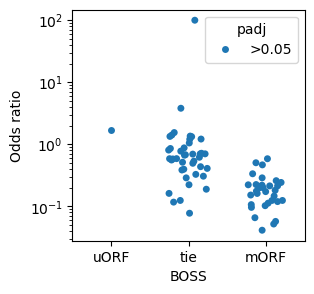

In [12]:
fig, ax = plt.subplots(figsize=(3,3))
sns.stripplot(data=boss, x='boss', y='odds_ratio', hue='padj', jitter=0.26, log_scale=True, ax=ax)
plt.xlabel('BOSS')
plt.ylabel('Odds ratio')
# plt.savefig('../results/park_2016_datasets/riboss/SRR3306588_9.boss.riboseqorfs.pdf', bbox_inches ='tight')

#### Performance assessment

In [13]:
rsi = pd.read_csv('../ref/tair10/Araport_uORF.intersection.txt')
brs = pd.merge(rsi, boss[boss.boss!='mORF'], how='outer')[['Araport_uORF','oid']]
brs['y_true'] = 1

brs_fn = brs[brs.oid.isna()].copy()
brs_fn['y_pred'] = -1
brs_tp = brs[~brs.oid.isna()].copy()
brs_tp['y_pred'] = 1

brs = pd.concat([brs_tp, brs_fn])
brs.drop('oid', axis=1, inplace=True)
brs.columns = ['id','y_true','y_pred']

In [14]:
rs_counts = pd.read_csv('../results/wu_2024_datasets/riboss/SRR15700008_13.riboprof.araport.txt', header=None, sep='\t')
rs_counts.columns = ['id','counts']
rs_counts = rs_counts[rs_counts['counts']>10].copy()
brs = pd.merge(brs, rs_counts[['id']])

brs.shape

(78, 3)

In [15]:
of_rt_id = pd.read_csv('../ref/tair10/orf_finder_ribotricer.intersection.txt', sep='\t')
brna = of_rt_id.copy()
brna['y_pred'] = -1
brna['y_true'] = -1
brna.drop('oid', axis=1, inplace=True)
brna.columns = ['id','y_pred','y_true']

brna.value_counts('y_pred')

y_pred
-1    104186
Name: count, dtype: int64

In [16]:
bperf = pd.concat([brna,brs])
bperf.to_pickle('../results/wu_2024_datasets/riboss/boss_perf.pkl.gz')
bperf.value_counts(['y_true','y_pred'])

y_true  y_pred
-1      -1        104186
 1       1            41
        -1            37
Name: count, dtype: int64

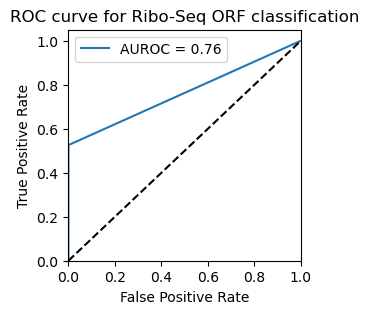

In [17]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, matthews_corrcoef, f1_score


fpr, tpr, thresholds = roc_curve(bperf.y_true, bperf.y_pred) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(3,3))  
plt.plot(fpr, tpr, label='AUROC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Ribo-Seq ORF classification')
plt.legend()

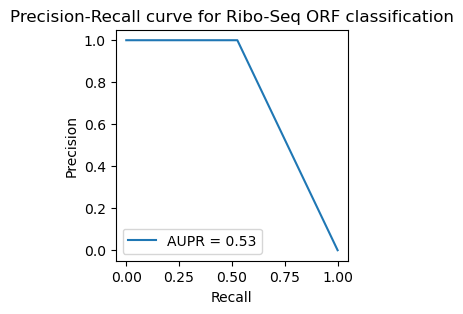

In [18]:
precision, recall, thresholds = precision_recall_curve(bperf.y_true, bperf.y_pred)
average_precision = average_precision_score(bperf.y_true, bperf.y_pred)

plt.figure(figsize=(3,3))
plt.plot(recall, precision, label='AUPR = %0.2f' % average_precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve for Ribo-Seq ORF classification")
plt.legend()

In [19]:
matthews_corrcoef(bperf.y_true, bperf.y_pred)

0.7248823482922329

In [20]:
f1_score(bperf.y_true, bperf.y_pred)

0.6890756302521008